In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

print('done')

done


In [7]:
train=pd.read_csv("../data/newyork/train.csv")
test=pd.read_csv("../data/newyork/test.csv")
test.shape

(625134, 9)

## Convert to appropriate datatype

convert pickup dateime and dropoff datetime into date-time object

In [8]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'],format = '%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Are there any missing values in the data?

In [10]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### What is the time period of the dataset?

In [12]:
print('Min pickup time: ', min(train['pickup_datetime']))
print('Max pickup time: ', max(train['pickup_datetime']))

Min pickup time:  2016-01-01 00:00:17
Max pickup time:  2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to Jun 2016

### Create new day,month,hour info from pickup time

In [13]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

In [33]:
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))


In [34]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,trip_distance,trip_duration_in_hour,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,1.498991,0.126389,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,1.806074,0.184167,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,6.387103,0.590000,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,1.485965,0.119167,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,1.188962,0.120833,40.793,-73.973,40.783,-73.973


### Based on Latitude and longitude get the distance of the trip in km
This uses Haversind Distance

In [19]:
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat =  radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat/2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a),sqrt(1-a))
    distance = R * c
    return distance

In [20]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,1.188962


In [23]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,1.188962,0.120833


### Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

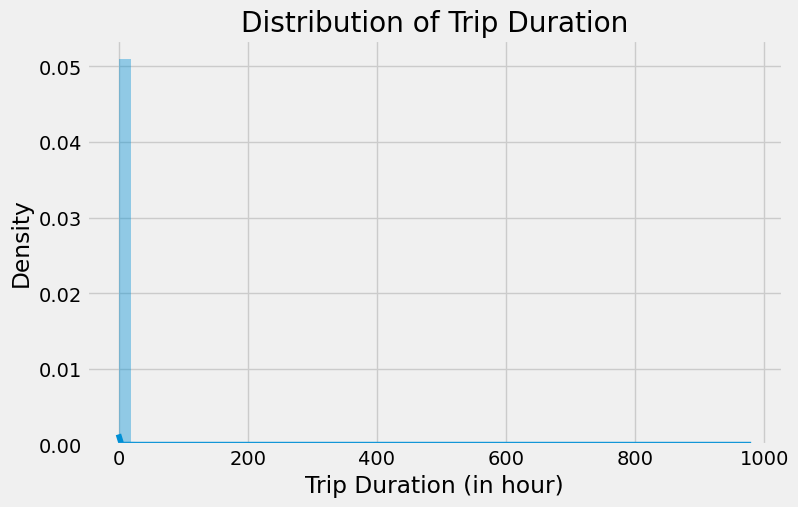

In [28]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

There are trip duration greater than 24 hours. We will have to investigate this?

In [29]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-05,5,0,Tuesday,2016-01-27,27,11,Wednesday,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-02-13,13,22,Saturday,2016-03-08,8,15,Tuesday,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-05,5,6,Tuesday,2016-01-31,31,1,Sunday,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-02-13,13,22,Saturday,2016-03-25,25,18,Friday,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let's take log transformation.

We will not remove these from the analysis, because they might be a a part of test data as well

Text(0.5, 1.0, 'Distribution of trip duration(sec) in Log Scale')

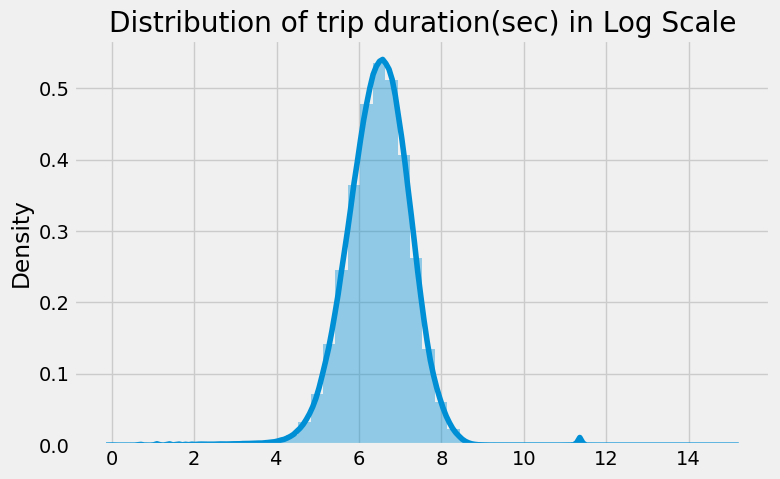

In [30]:
plt.figure(figsize=(8,5))

sns.distplot(np.log(train['trip_duration'].values)).set_title('Distribution of Trip Duration')
plt.title('Distribution of trip duration(sec) in Log Scale')

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are within New York

### Heatmap of common locations from where pickup and dropoff occurs

In [36]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1


In [39]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.astype(float).values)),
                  min_opacity=0.2, 
                  radius=5, 
                  blur=15, 
                  max_zoom=1
                  )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

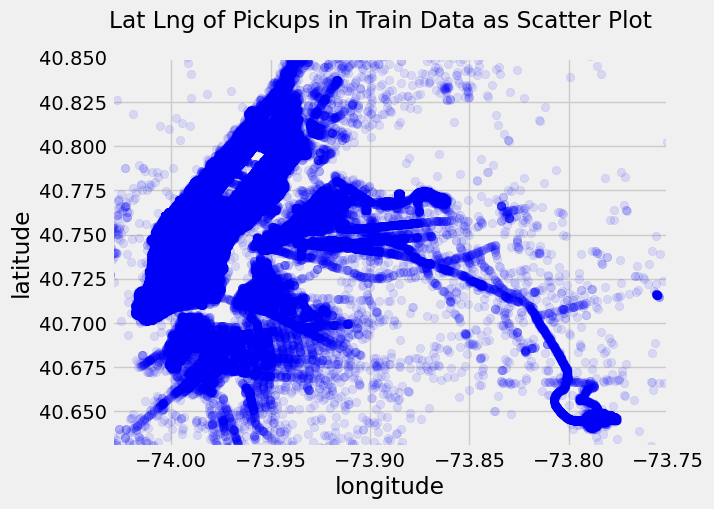

In [38]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### This graph clearly shows heavy density of pickups near JFK

In [41]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [42]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in drop.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.astype(float).values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)




drop_map

Dropoff Heatmap is similar to pickup

### heatmap of trip duration, when pickup originates from a point

Text(0.5, 1.0, 'Pickup Hours Distribution')

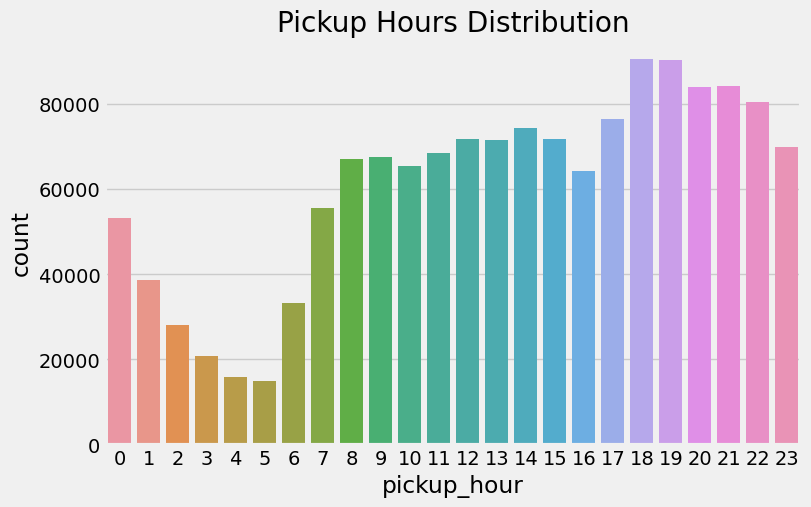

In [43]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')